In [26]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Build Pandas Dataframe

In [27]:
dataset_name_clean = "data_full_clean.txt"
dataset_path = ".\\data\\"

with open(dataset_path+dataset_name_clean) as json_file:
    data = json.load(json_file)

In [28]:
# Get column names
columns = list(data['0'].keys())
columns.remove('album_url')

records = []

for item in data.keys():
    record = []
    for col in columns:
        record.append(data[item][col])
    records.append(record)

albums_df = pd.DataFrame(records, columns=columns)
albums_df.head()

,artist_id,artist_name,album_id,album_name,album_popularity,genres,filepath
0,5me0Irg2ANcsgc93uaYrpb,The Notorious B.I.G.,7dRdaGSxgcBdJnrOviQRuB,Life After Death (2014 Remastered Edition),78,"[east coast hip hop, gangster rap, hardcore hi...",.\images\7dRdaGSxgcBdJnrOviQRuB.jpg
1,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,6P5QHz4XtxOmS5EuiGIPut,Led Zeppelin III (Remaster),74,"[album rock, classic rock, hard rock, rock]",.\images\6P5QHz4XtxOmS5EuiGIPut.jpg
2,5WUlDfRSoLAfcVSX1WnrxN,Sia,77jAfTh3KH9K2reMOmTgOh,This Is Acting,74,"[australian dance, australian pop, dance pop, ...",.\images\77jAfTh3KH9K2reMOmTgOh.jpg
3,0dEvJpkqhrcn64d3oI8v79,Barenaked Ladies,0DuFDnZcj7B4R0Jik1aDmY,Stunt (20th Anniversary Edition),66,"[canadian pop, canadian rock, comic, pop rock]",.\images\0DuFDnZcj7B4R0Jik1aDmY.jpg
4,2BvzbqWWwLN11XGBYgDZzx,Terror Squad,0NTYMm0B7adXejff1phD3F,True Story,60,"[bronx hip hop, hardcore hip hop]",.\images\0NTYMm0B7adXejff1phD3F.jpg


## Explore Album Popularity

Check the distribution of the album `popularity` column. Spotify API returns a value in range (0, 100)

Text(0.5, 0, 'Popularity')

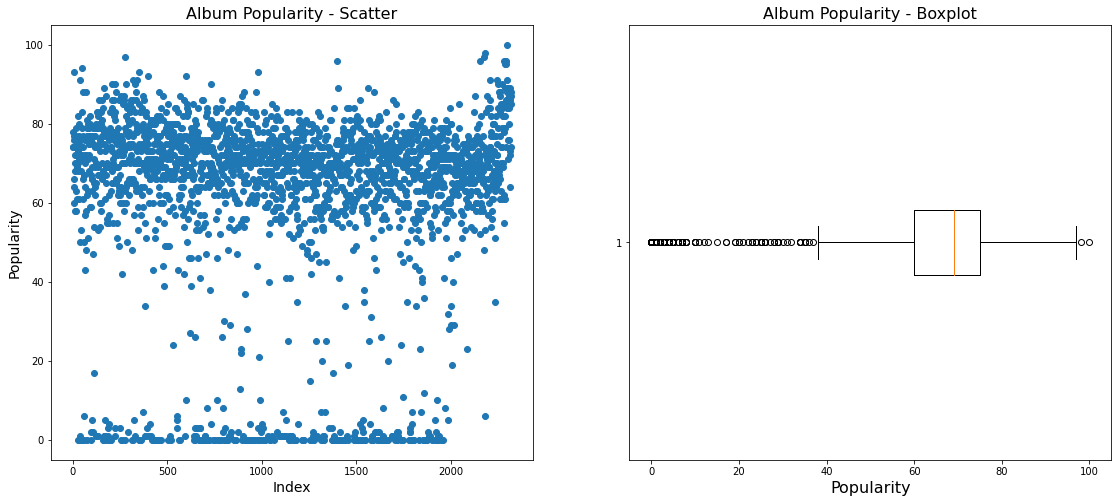

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,8))

x = albums_df.album_popularity
y = x.index
ax1.scatter(y, x)
ax1.set_ylabel("Popularity", size = 14)
ax1.set_xlabel("Index", size = 14)
ax1.set_title("Album Popularity - Scatter", size = 16)

ax2.set_title('Album Popularity - Boxplot', size = 16)
ax2.boxplot(x=albums_df['album_popularity'], vert = False)
ax2.set_xlabel("Popularity", size = 16)

## Filter out albums with low popularity

Keep records above a `popularity threshold`.

In [30]:
popularity_threshold = 40

popular = albums_df.album_popularity > popularity_threshold

albums_df = albums_df[popular]

Text(0.5, 0, 'Popularity')

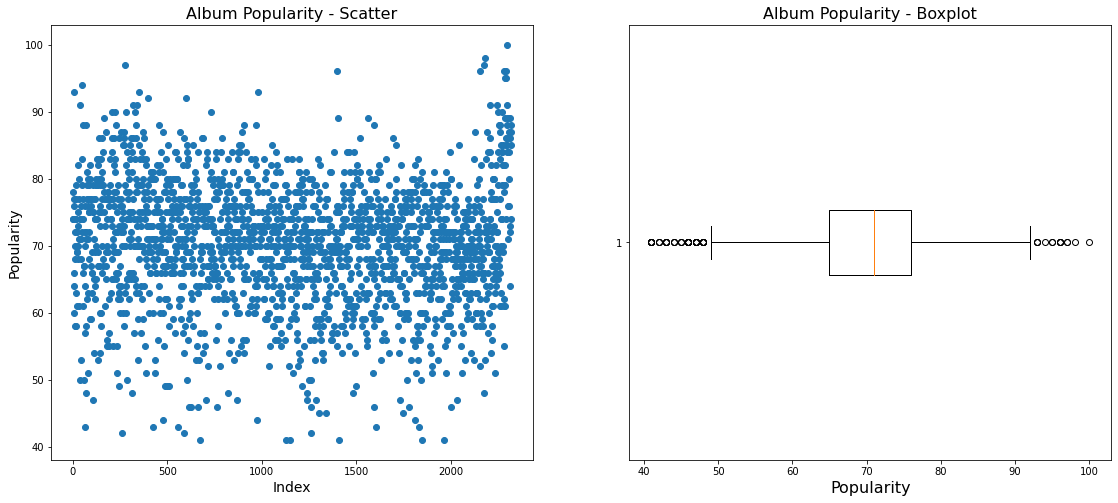

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,8))

x = albums_df.album_popularity
y = x.index
ax1.scatter(y, x)
ax1.set_ylabel("Popularity", size = 14)
ax1.set_xlabel("Index", size = 14)
ax1.set_title("Album Popularity - Scatter", size = 16)

ax2.set_title('Album Popularity - Boxplot', size = 16)
ax2.boxplot(x=albums_df['album_popularity'], vert = False)
ax2.set_xlabel("Popularity", size = 16)

## Genres Analysis

Spotify API returns multiple genres per artist as a list. The following part handles the list values and computes the distribution and corellation between different genres.



In [32]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

genres_freq = to_1D(albums_df['genres']).value_counts()

Firstly we remove the least frequent `genres`.

In [33]:
min_genre_count = 100

genres_to_keep = genres_freq[genres_freq > min_genre_count].index
genres_to_keep

Index(['pop', 'dance pop', 'pop dance', 'pop rap', 'rap', 'post-teen pop',
       'rock', 'hip hop', 'edm', 'trap', 'tropical house', 'electropop',
       'pop rock', 'southern hip hop', 'modern rock', 'classic rock'],
      dtype='object')

In [34]:
genre_list = list(albums_df['genres'])

for index, genre_l in enumerate(genre_list):
    _list = []
    for genre in genre_l:
          if genre in genres_to_keep:
                _list.append(genre)
    genre_list[index] = _list

    
albums_df['genres'] = genre_list

In [35]:
albums_df = albums_df[albums_df['genres'].map(len) > 0]

The distribution of the remaining `genres`.

In [36]:
to_1D(albums_df['genres']).value_counts()

pop                 840
dance pop           685
pop dance           470
pop rap             391
rap                 364
post-teen pop       354
rock                250
hip hop             247
edm                 229
trap                214
tropical house      206
electropop          154
pop rock            147
southern hip hop    138
modern rock         110
classic rock        101
dtype: int64

Text(0.5, 1.0, 'Album Genre')

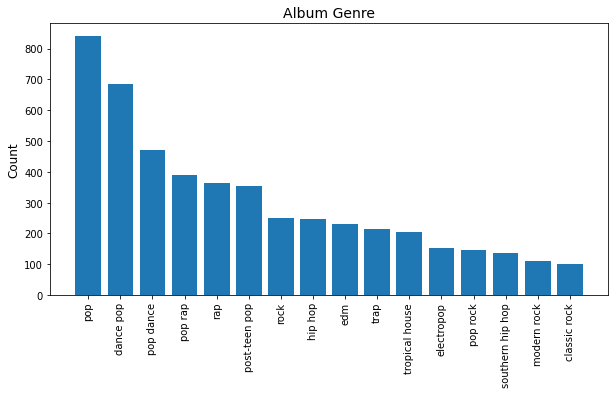

In [37]:
genres_freq = to_1D(albums_df['genres']).value_counts()

fig, ax = plt.subplots(figsize = (10,5))

ax.bar(genres_freq.index, genres_freq.values)
plt.xticks(rotation = 90)
ax.set_ylabel("Count", size = 12)
ax.set_title("Album Genre", size = 14)

In [38]:
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [39]:
genres_bool = boolean_df(albums_df['genres'], genres_to_keep)

In [40]:
genres_corr = genres_bool.corr(method = "pearson")

Text(0.5, 1.0, 'Album Genres - Corellation Matrix')

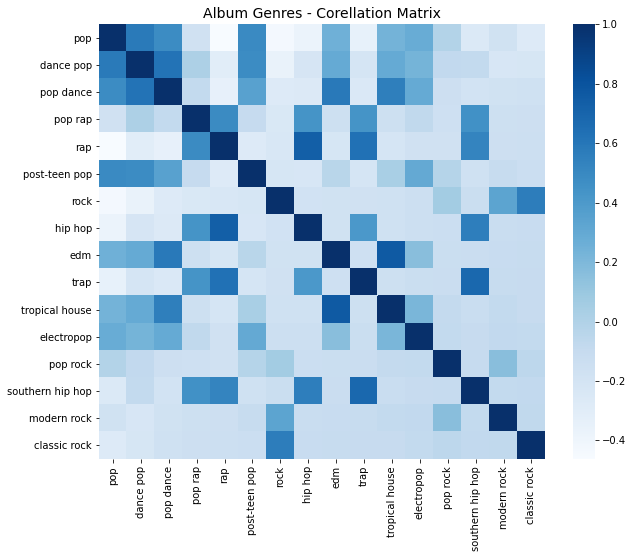

In [41]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(genres_corr, cmap = "Blues")

ax.set_title("Album Genres - Corellation Matrix", size = 14)

In [42]:
for i in genres_corr.columns:
    print(f"{i}  -> [" ,end='')
    for name, value  in genres_corr[i].iteritems():
        if value > 0.5 and i != name:
            print(f"'{name}', ", end='')
    print(']')

pop  -> ['dance pop', ]
dance pop  -> ['pop', 'pop dance', ]
pop dance  -> ['dance pop', 'edm', 'tropical house', ]
pop rap  -> []
rap  -> ['hip hop', 'trap', 'southern hip hop', ]
post-teen pop  -> []
rock  -> ['classic rock', ]
hip hop  -> ['rap', 'southern hip hop', ]
edm  -> ['pop dance', 'tropical house', ]
trap  -> ['rap', 'southern hip hop', ]
tropical house  -> ['pop dance', 'edm', ]
electropop  -> []
pop rock  -> []
southern hip hop  -> ['rap', 'hip hop', 'trap', ]
modern rock  -> []
classic rock  -> ['rock', ]


## Final Selection of Genres

For the purposes of genre classification, we will keep the following labels:

- pop
- rap
- rock

We will now replace genres that have a high corellation with one of the above genres.

In [43]:
genre_list = list(albums_df['genres'])

pop_label = ['dance pop', 'pop dance', 'post-teen pop','edm', 'tropical house', 'electropop','electro house']
rap_label = ['pop rap', 'hip hop', 'trap', 'southern hip hop', 'melodic rap', 'urban contemporary', 'r&b']
rock_label = ['classic rock', 'modern rock']

genres_to_remove = ['pop rock']

for index, genre_l in enumerate(genre_list):
    _list = []

    for i, genre in enumerate(genre_l):
        
        if genre in pop_label:
            genre_l[i] = 'pop'
        elif genre in rap_label:
            genre_l[i] = 'rap'
        elif genre in rock_label:
            genre_l[i] = 'rock'
        elif genre in genres_to_remove:
            genre_l[i] = None
        else:
            pass
    genre_l = list(filter(None, genre_l)) 
    genre_l = list(set(genre_l))
    
    if len(genre_l) > 1:
        genre_l = [genre_l[0]]

    genre_list[index] = genre_l  

    
albums_df['genres'] = genre_list

In [44]:
albums_df = albums_df[albums_df['genres'].map(len) > 0]

df = albums_df.genres.apply(frozenset).to_frame(name='genre')
for genre in frozenset.union(*df.genre):
     df[genre] = df.apply(lambda _: int(genre in _.genre), axis=1)

albums_df = pd.concat([albums_df, df], axis=1) 

In [45]:
albums_df = albums_df.drop(['genre'], axis=1)

In [46]:
albums_df.head()

,artist_id,artist_name,album_id,album_name,album_popularity,genres,filepath,rap,rock,pop
0,5me0Irg2ANcsgc93uaYrpb,The Notorious B.I.G.,7dRdaGSxgcBdJnrOviQRuB,Life After Death (2014 Remastered Edition),78,[rap],.\images\7dRdaGSxgcBdJnrOviQRuB.jpg,1,0,0
1,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,6P5QHz4XtxOmS5EuiGIPut,Led Zeppelin III (Remaster),74,[rock],.\images\6P5QHz4XtxOmS5EuiGIPut.jpg,0,1,0
2,5WUlDfRSoLAfcVSX1WnrxN,Sia,77jAfTh3KH9K2reMOmTgOh,This Is Acting,74,[pop],.\images\77jAfTh3KH9K2reMOmTgOh.jpg,0,0,1
5,246dkjvS1zLTtiykXe5h60,Post Malone,4g1ZRSobMefqF6nelkgibi,Hollywood's Bleeding,93,[rap],.\images\4g1ZRSobMefqF6nelkgibi.jpg,1,0,0
8,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,Oops!... I Did It Again,76,[rap],.\images\5PmgtkodFl2Om3hMXONDll.jpg,1,0,0


Text(0.5, 1.0, 'Album Genre')

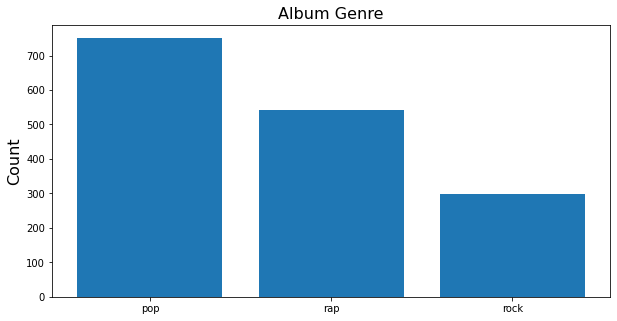

In [47]:
genres_freq = to_1D(albums_df['genres']).value_counts()

fig, ax = plt.subplots(figsize = (10,5))

ax.bar(genres_freq.index, genres_freq.values)

ax.set_ylabel("Count", size = 16)
ax.set_title("Album Genre", size = 16)

In [48]:
pd.to_pickle(albums_df, "./albums_df.pkl")